# 분류 모델
- 분류(classification): 카테고리 구분을 예측하는 것
- 컨퓨전 매트릭스와 분류의 성능 지표인 정확도(accuracy), 정밀도(precision), 리콜(recall), f-1 점수 이해
- 오분류가 발생한 샘플 찾기
- 내부 점수 보기 (decision_function)
- 분류 경계값 (threshold)를 바꾸어 정밀도와 리콜을 다르게 선택하는 방법

# import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (5,5)
plt.rcParams.update({'font.size': 13})

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve

from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

# 컨퓨전 매트릭스
- 아래는 이진 분류의 컨퓨전 매트릭스 정의이다

<img src="https://raw.githubusercontent.com/data-labs/image/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-01-07%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%201.44.12.png?raw=1" width=450 align='left'>



##  예시
 - 총 100명을 진단하고 9명을 양성이라고 예측했으나 실제로 양성은 6명, 음성은 3명
 - 91명을 음성이라고 예측했으나 실제로 음성은 87명, 양성은 4명

<img src="https://raw.githubusercontent.com/data-labs/image/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-01-07%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%201.49.05.png?raw=1" width=450 align='left'>

## 분류 기본 성능 평가
- Accuracy (정확도): 전체 맞춘 비율 (TP+TP) / (TP+FP+FN+FP)
- Precision: positive로 예측한 것 중 실제로 맞는 비율, TP / (TP+FP)
- Recall (Sensitivity):  전체 positive 중 모델이 찾아낸 비율, TP / (TP+FN)
- f1-score: Precision과 Recall의 조화 평균 (2 x  Precision x Recall) /  (Precision + Recall)

- Accuracy (정확도): 93/100
- Precision: 6/9
- Recall (Sensitivity):  6/10

<img src="https://raw.githubusercontent.com/data-labs/image/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-01-07%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%201.56.47.png?raw=1" width = 530 align='left'>

### (참고) 조화평균
- f-1 점수는 정밀도와 리콜의 조화평균(harmonic average)이다

- 점수들이 조화로울수록 (서로 차이가 작을수록) 조화평균 점수가 높다

- a, b의 산술 평균, $c = $${(a + b)}\over {2}$
- a, b의 조화 평균 $c$, ${1}\over{c}$ =  ($1\over{a}$+${1}\over{b}$) $/ 2$   
> $c = $ ${2ab}\over{(a+b)}$

# 남여 분류 문제

(1000, 3)


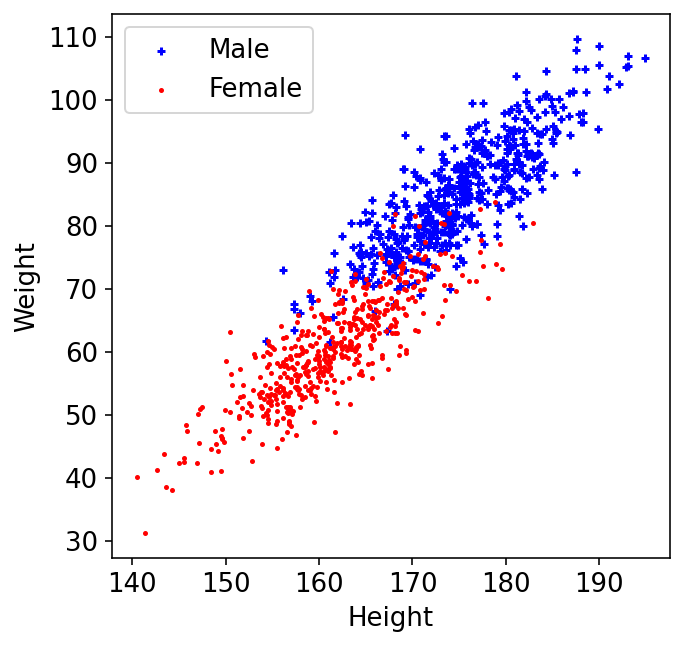

In [4]:
## 남녀 키, 몸무게 데이터 읽기

data = pd.read_csv("https://github.com/data-labs/data/raw/main/weight-height500.csv")
print(data.shape)
data.Gender = data.Gender.map({'Male':1, 'Female':0})
df = data.copy()

# 남성(1)은 파란색(+), 여성(0)은 붉은색(.)
plt.scatter(df.Height[df.Gender==1],df.Weight[df.Gender==1],
            marker='+', s=13, color='b', label='Male')
plt.scatter(df.Height[df.Gender==0],df.Weight[df.Gender==0],
            marker='.', s=9, color='r', label='Female')
plt.xlabel('Height')
plt.ylabel('Weight')
plt.legend()

## 이진 분류 모델
- 키과 몸무게를 보고 성별를 예측
- X: 키와 몸무게 (2개의 특성을 사용)
- y: 성별 (남여를 구분하는 이진 분류 문제)

In [5]:
## 키와 몸무게를 보고 성별을 구분하는 분류 문제

X = df[["Height", "Weight"]]
y = df.Gender

# 스케일링
X_sc = X.copy()
scaler = StandardScaler()
X_sc.loc[:,:] = scaler.fit_transform(X_sc)

# 훈련 데이터, 검증 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(X_sc, y, random_state=9)

# 선형 분류 모델
model = SGDClassifier() # (1) 모델 생성
model.fit(X_train, y_train) # (2) 훈련

# 결과 보기
print('정확도: ',model.score(X_test, y_test)) # (3) 평가 (정확도)
a1, a2, b = model.coef_[0][0], model.coef_[0][1], model.intercept_[0]
print('a1, a2, b =', np.array((a1, a2, b)).round(4))

정확도:  0.908
a1, a2, b = [-1.8453  6.3363  0.1797]


## 혼돈 매트릭스와 분류 평가 점수 보기

In [6]:
def show_clf_result(y_test, y_pred):
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

In [7]:
## 혼돈 매트릭스와 분류 평가 점수 보기

y_pred = model.predict(X_test)
show_clf_result(y_test, y_pred)

[[116  15]
 [  8 111]]
              precision    recall  f1-score   support

           0       0.94      0.89      0.91       131
           1       0.88      0.93      0.91       119

    accuracy                           0.91       250
   macro avg       0.91      0.91      0.91       250
weighted avg       0.91      0.91      0.91       250



- support는 레이블 별 샘플수
- macro 평균은 성능평가 점수들을 단순히 산술평균을 구한 것
- weighted 평균은 샘플의 갯수를 고려하여 가중평균을 구한 것

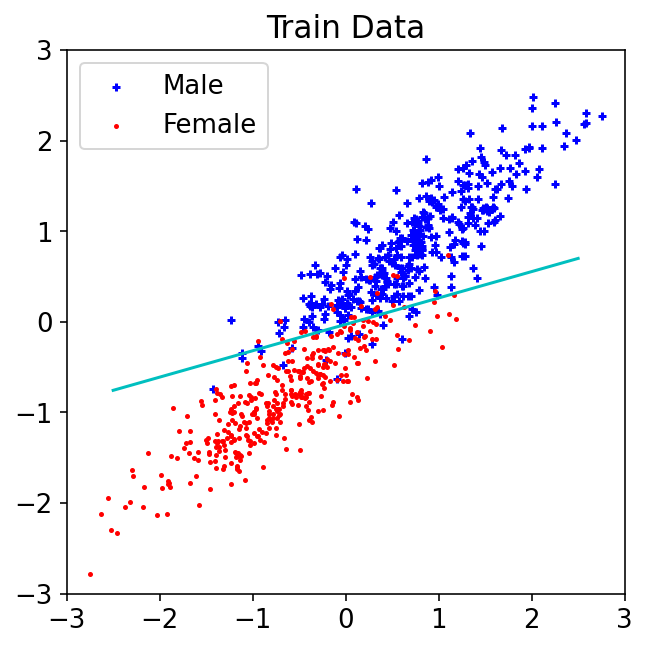

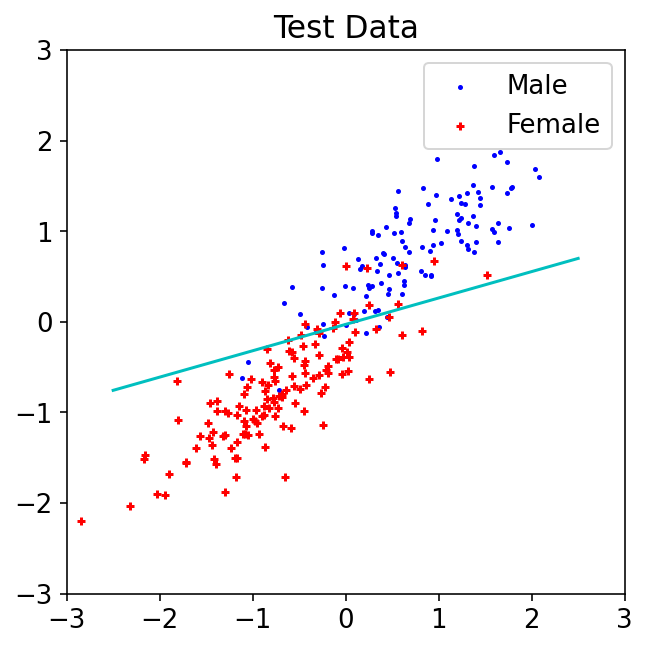

In [8]:
## 훈련 데이터 결정 경계와 테스트 데이터에 적용한 결과

xs = np.array((-2.5, 2.5))
ys = -(a1/a2)*xs - b/a2

# 훈련 데이터 결정 경계 그리기
plt.title('Train Data')
plt.plot(xs,ys, c='c')
plt.scatter(X_train.Height[y_train==1],X_train.Weight[y_train==1],
            marker='+', s=13, color='b', label='Male')
plt.scatter(X_train.Height[y_train==0],X_train.Weight[y_train==0],
            marker='.', s=9, color='r', label='Female')
plt.ylim([-3,3])
plt.xlim([-3,3])
plt.legend()
plt.show()

# 테스트 데이터에 적용한 결과
plt.title('Test Data')
plt.plot(xs,ys, c='c')
plt.scatter(X_test.Height[y_test==1],X_test.Weight[y_test==1],
            marker='.', s=9, color='b', label='Male')
plt.scatter(X_test.Height[y_test==0],X_test.Weight[y_test==0],
            marker='+', s=13, color='r', label='Female')
plt.ylim([-3,3])
plt.xlim([-3,3])
plt.legend()

## 예측 결과 보기
- X_test, 실제값 y_test, 예측값 y_pred, 분류점수(score) 보기

In [9]:
df_test = X_test.copy()
df_test['y_test'] = y_test
df_test['y_pred'] = y_pred
score =  model.decision_function(X_test)
df_test['score'] = score
df_test[:10]

,Height,Weight,y_test,y_pred,score
2,2.079318,1.596700,1,1,6.459848
879,-2.173641,-1.514612,0,0,-5.406222
57,1.205080,0.967941,1,1,4.089100
496,-1.047874,-0.441888,1,0,-0.686551
611,-1.300498,-0.979650,0,0,-3.627783
45,1.029566,0.870267,1,1,3.794095
200,1.314566,1.088004,1,1,4.647817
665,-1.299448,-1.253866,0,0,-5.367219
603,1.523990,0.517816,0,1,0.648509
299,0.247375,0.374415,1,1,2.095624


In [10]:
# 잘 못 예측한 샘플 보기

df_false = df_test[df_test.y_test != df_test.y_pred]
df_false

,Height,Weight,y_test,y_pred,score
496,-1.047874,-0.441888,1,0,-0.686551
603,1.523990,0.517816,0,1,0.648509
65,-0.235143,-0.156678,1,0,-0.379123
148,0.006778,-0.030417,1,0,-0.025518
916,0.948371,0.672907,0,1,2.693397
768,0.604085,0.626283,0,1,3.033289
548,0.005975,0.619447,0,1,4.093673
794,0.255460,0.187032,0,1,0.893400
844,-0.475159,-0.146825,0,1,0.126214
24,0.449932,0.049377,1,0,-0.337674


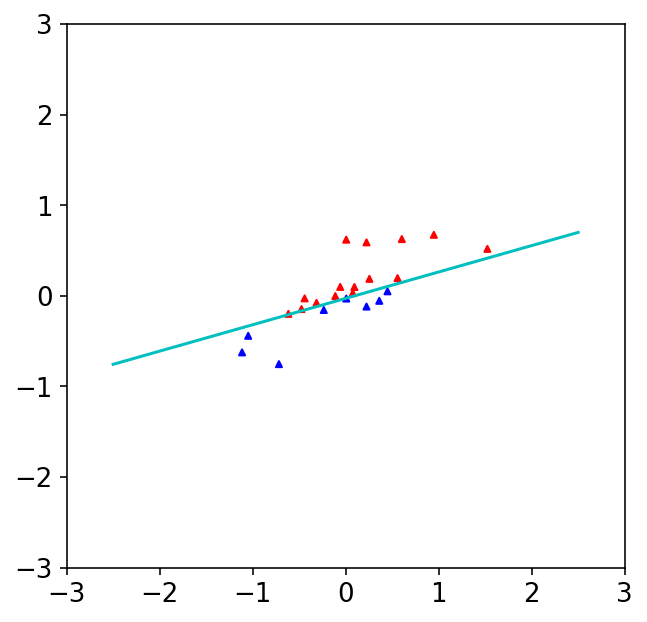

In [11]:
# 잘 못 예측한 샘플을 그래프에 표시한다

xs = np.array((-2.5, 2.5))
ys = -(a1/a2)*xs - b/a2
plt.plot(xs,ys, c='c')

plt.scatter(df_false.Height,df_false.Weight,
            c=df_false.y_test, s=9, cmap='bwr_r', marker='^')

plt.ylim([-3,3])
plt.xlim([-3,3])
plt.show()

## 이진 분류 결정 경계
- decision boundary
- 하나의 변수만 사용하는 경우 결정 경계: $x_{1} > b$  
- 두 개의 변수를 사용하는 경우 결정 경계: (점수) $a_{1}x_{1}+a_{2}x_{2}+b >0$  
     > $x_{2} > -$$a_{1}\over a_{2}$ $x_{1} - $$b\over{a_{2}}$


<img src="https://raw.githubusercontent.com/data-labs/image/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-01-09%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%205.19.06.png?raw=1" width=500 align='left'>


## 분류 점수

- 분류를 수행하기 위해서 내부적으로 계산하는 점수(score)
> score: $a_{1}x_{1}+a_{2}x_{2}+b >0$  
     
- 점수를 제공하는 모델: 선형모델, SVM
 - 각 샘플별 점수는 decision_function()으로 얻는다
- 확률을 사용하는 모델: 트리계열, 랜덤포레스트, 부스팅, 로지스틱회귀, 신경망
 - 각 샘플별 분류 확률은 predict_proba()으로 얻는다

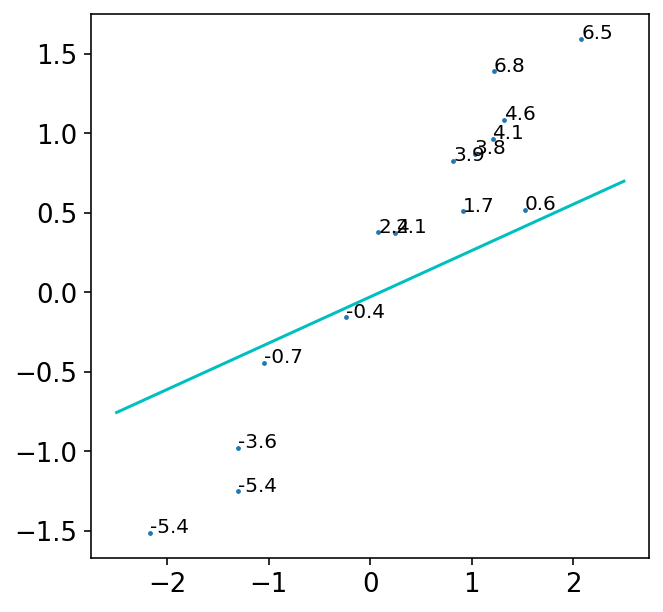

In [12]:
# 15개의 테스트 샘플의 점수만 보겠다

N = 15
xs = np.array((-2.5, 2.5))
ys = -(a1/a2)*xs - b/a2
plt.plot(xs,ys, c='c')

plt.scatter(df_test[:N].Height,df_test[:N].Weight, s=2)

for i in range(N):
    plt.text(df_test[:N].Height.iloc[i],df_test[:N].Weight.iloc[i],
             df_test[:N].score.values.round(1)[i],
             fontsize=10)

# 정밀도, 리콜 변경하기
- 경계값을 바꾸어 다른 예측 모델을 얻는다

In [13]:
y_pred[:20]

array([1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1])

In [14]:
((score > 0)*1)[:20]

array([1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1])

In [15]:
## 높은 정밀도를 갖는 예측 모델을 만들려면 경계값을 높인다

new_y_pred = score > 0
show_clf_result(y_test, new_y_pred)

[[116  15]
 [  8 111]]
              precision    recall  f1-score   support

           0       0.94      0.89      0.91       131
           1       0.88      0.93      0.91       119

    accuracy                           0.91       250
   macro avg       0.91      0.91      0.91       250
weighted avg       0.91      0.91      0.91       250



In [16]:
# 새로운 예측 모델 보기
new_y_pred * 1

array([1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 1])

## P-R 변화 보기

Text(0, 0.5, 'precision')

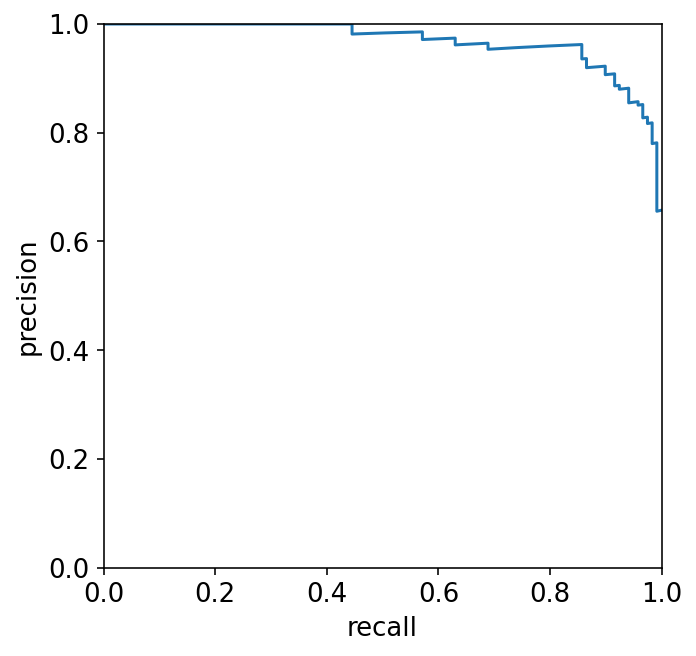

In [17]:
# sklearn이 제공하는 함수 precision_recall_curve를 사용해서 직접 그리기
plt.figure(figsize=(5,5))

prec,rcl,thres = precision_recall_curve(y_test,score)
plt.plot(rcl, prec)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("recall")
plt.ylabel("precision")

## P-R 값 테이블

In [18]:
prec.shape, rcl.shape, thres.shape

((182,), (182,), (181,))

In [19]:
df_PR = pd.DataFrame({'prec':prec, 'recall':rcl})

# thres의 길이가 하나 적으므로 pres, recall의 크기를 하나 줄인다
df_PR = df_PR[:-1]
df_PR["thres"] = thres
df_PR = df_PR[::-1] # 내림차순으로 순서를 바꾼다
df_PR

,prec,recall,thres
180,1.000000,0.008403,9.769101
179,1.000000,0.016807,8.990833
178,1.000000,0.025210,8.938872
177,1.000000,0.033613,8.506748
176,1.000000,0.042017,8.298600
...,...,...,...
4,0.666667,0.991597,-3.049700
3,0.662921,0.991597,-3.075655
2,0.659218,0.991597,-3.268330
1,0.655556,0.991597,-3.274470


<AxesSubplot:>

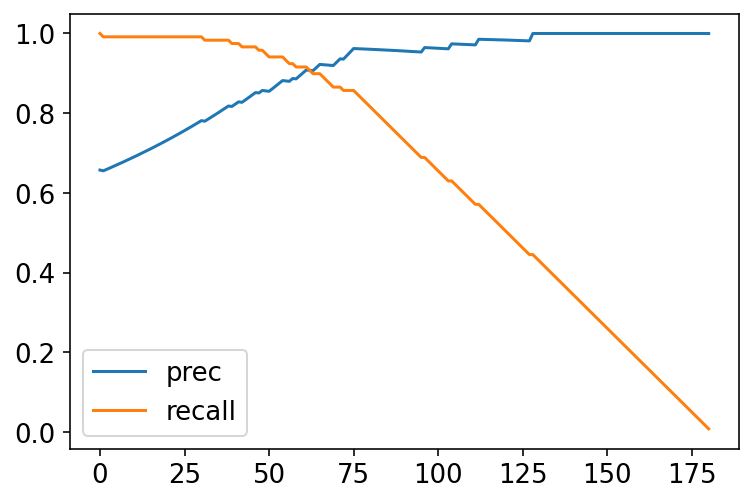

In [20]:
df_PR[['prec','recall']].plot(figsize=(6,4))

# ROC 커브 그리기

- response of characteristics (ROC)
- roc_curve()를 사용한다
- roc_curve()를 사용한다

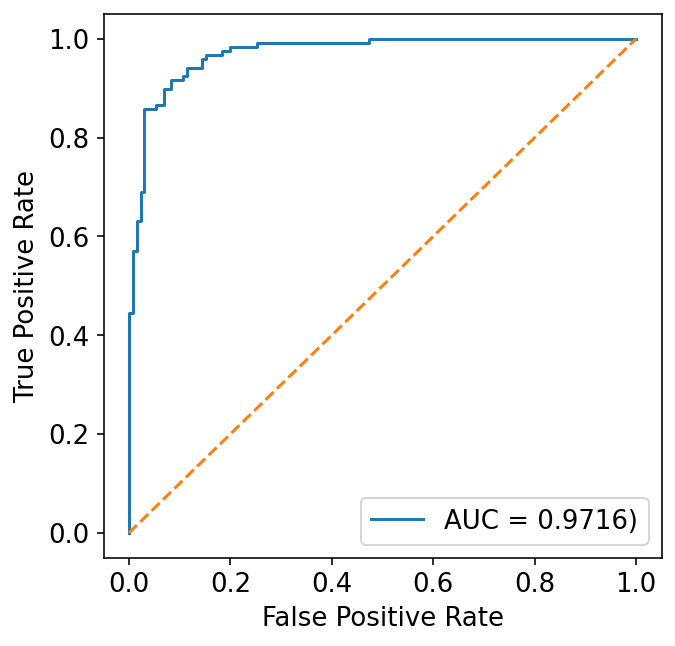

In [21]:
## ROC 커브 그리기 (roc_curve 함수 사용)

fpr,tpr,_ = roc_curve(y_test,score)

# AUC(면적) 계산하기
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='AUC = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

# (실습) 오분류 샘플 보기
- 위의 모델에서 1)남성을 여성으로, 2)여성을 남성으로 오분류된 X_test 샘플을 각각 찾아보시오

# (실습) 정밀도, 재현율 바꾸기

- 남성 예측에 대해서 precision이 0.99가 되는 모델을 만드시오
- 남성 예측에 대해서 recall이 0.99가 되는 모델을 만드시오
